# Getting Started | ST-GCN with OpenPack Dataset (Keypoint)

## [0] Inital Setup

### 0-1: Download Code and Install `openpack-torch` 
NOTE: You can also install `openpack-torch` from PyPI with `pip install openpack-torch`.

In [ ]:
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

In [1]:
! cd /content/openpack-torch/ && pip install .

Defaulting to user installation because normal site-packages is not writeable
Processing /home/bob/openpack-torch
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openpack-torch: filename=openpack_torch-0.2.0-py3-none-any.whl size=18921 sha256=b226d3d2e0c450e1ae9e054d2f747f55358999c8e16f2631ef862697543db04d
  Stored in directory: /home/bob/.cache/pip/wheels/9e/aa/9d/cad8d0b1efb54b3f83948f6641caa69c9d6dc2e97c596315e2
Successfully built openpack-torch
  Attempting uninstall: openpack-torch
    Found existing installation: openpack-torch 0.2.0
    Uninstalling openpack-torch-0.2.0:
      Successfully uninstalled openpack-torch-0.2.0


### 0-2: Download Dataset to  `/content/data`
- Souce: https://doi.org/10.5281/zenodo.5909086

In [2]:
! mkdir -p /content/data/datasets/
! optk-download -d /content/data/datasets -v v0.2.0 -s kinect-2d-kpt,openpack-operations

INFO:openpack_toolkit.bin.download:Donwload OpenPack dataset from zenodo.
INFO:openpack_toolkit.bin.download: - dataset_dir : /content/data/datasets
INFO:openpack_toolkit.bin.download: - version     : v0.2.0
INFO:openpack_toolkit.bin.download: - streams     : ['kinect-2d-kpt', 'openpack-operations']
INFO:openpack_toolkit.download._helpers:== [0/2] kinect-2d-kpt ==
INFO:openpack_toolkit.download._helpers:[0/4] U0102
INFO:openpack_toolkit.download._helpers:  download https://zenodo.org/record/6697990/files/U0102__kinect__2d-kpt.zip?download=1 ...
INFO:openpack_toolkit.download._helpers:  unzip /content/data/datasets/openpack/v0.2.0/zenodo/U0102__kinect__2d-kpt.zip to /content/data/datasets/openpack/v0.2.0 ...
INFO:openpack_toolkit.download._helpers:  done!
INFO:openpack_toolkit.download._helpers:[1/4] U0103
INFO:openpack_toolkit.download._helpers:  download https://zenodo.org/record/6697990/files/U0103__kinect__2d-kpt.zip?download=1 ...
INFO:openpack_toolkit.download._helpers:  unzip /co

### 0-3: Import Modules

In [3]:
import os
import shutil
import logging
from pathlib import Path
from typing import Dict

import hydra
import numpy as np
import openpack_toolkit as optk
import openpack_torch as optorch
import pandas as pd
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from hydra import initialize_config_dir, compose
from omegaconf import DictConfig, OmegaConf
from openpack_toolkit import OPENPACK_OPERATIONS
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)


sns.set("notebook", "whitegrid")

### 0-4: Setup Logger

In [4]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

2022-06-28 15:45:38 | INFO | __main__ | info
2022-06-28 15:45:38 | WARNING | __main__ | warning


## [1] Load Config File

In [5]:
optorch.configs.register_configs()

In [13]:
config_dir = Path("/content/openpack-torch/examples/st-gcn/configs")
overrides = [
    "mode=train",
    "issue=I01-EXP1-V1-nb",
    "debug=false",
    "train.batch_size=8",
    "datarootdir=/content/data",
    "hydra/job_logging=custom",
    "hydra/hydra_logging=disabled"
]

with initialize_config_dir(version_base=None, config_dir=str(config_dir)):
    cfg = compose(
        config_name="operation-segmentation.yaml",
        overrides=overrides,
    )
print(OmegaConf.to_yaml(cfg))

dataset:
  name: openpack-2d-kpt
  streams: null
  stream:
    schema: KeypointConfig
    name: kinect-2d-kpt
    description: 2D keypoint extracted by mmpose/hrnet. The model used to extract
      keypoints was 2-stage bottom-up model defined in [mmpose/2d_kpt_sview_rgb_vid/posewarper/posetrack18/hrnet_w48_posetrack18_384x288_posewarper_stage2.py](https://github.com/open-mmlab/mmpose/blob/master/configs/body/2d_kpt_sview_rgb_vid/posewarper/posetrack18/hrnet_w48_posetrack18_384x288_posewarper_stage2.py).
    super_stream: None
    path:
      dir: ${path.openpack.rootdir}/${user.name}/kinect/${..category}/${..model}/single
      fname: ${session}.json
    file_format: null
    frame_rate: 15
    category: 2d-kpt
    model: mmpose-hrnet-w48-posetrack18-384x288-posewarper-stage2
    nodes:
      0: nose
      1: left_eye
      2: right_eye
      3: left_ear
      4: right_ear
      5: left_shoulder
      6: right_shoulder
      7: left_elbow
      8: right_elbow
      9: left_wrist
     

## [2] Define Utilities (Pytorch Lightning Modules)

### 2-1: DataModule

Override `optorch.data.OpenPackBaseDataModule` to use Keypoint data.

In [14]:
class OpenPackKeypointDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackKeypoint

    def get_kwargs_for_datasets(self) -> Dict:
        submission = True if self.cfg.mode == "submission" else False

        kwargs = {
            "debug": self.cfg.debug,
            "window": self.cfg.train.window,
            "submission": submission,
        }
        return kwargs

### 2-2: Lightning Module

In [17]:
class STGCN4SegLM(optorch.lightning.BaseLightningModule):

    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        in_ch = 2
        Ks = cfg.model.Ks
        A = optorch.models.keypoint.get_adjacency_matrix(
            layout="MSCOCO", hop_size=Ks - 1)
        
        model = optorch.models.keypoint.STGCN4Seg(
            in_ch,
            len(OPENPACK_OPERATIONS),
            Ks=cfg.model.Ks,
            Kt=cfg.model.Kt,
            A=A,
        )
        return model

    def training_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        return outputs

## [3] Train U-Net

### 3-1: Initialize U-Net Model and DataLoader.

In [18]:
device = torch.device("cuda")
logdir = Path.cwd()
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackKeypointDataModule(cfg)
plmodel = STGCN4SegLM(cfg).to(dtype=torch.float, device=device)

In [19]:
plmodel

STGCN4SegLM(
  (net): STGCN4Seg(
    (bn): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stgc1): STConvBlock(
      (sgc): SpatialGraphConvLayer(
        (conv): Conv2d(2, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (tgc): TemporalConvLayer(
        (block): Sequential(
          (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Dropout(p=0.5, inplace=False)
          (3): Conv2d(32, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
    )
    (stgc2): STConvBlock(
      (sgc): SpatialGraphConvLayer(
        (conv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (tgc): TemporalConvLayer(
        (block): Sequential(
          (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

### 3-2: Initialize Trainer

In [20]:
# num_epoch = cfg.train.debug.epochs if cfg.debug else cfg.train.epochs
num_epoch = 10

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=0,
    save_last=True,
    monitor=None,
)

trainer = pl.Trainer(
    gpus=[0],
    max_epochs=num_epoch,
    logger=False,  # disable logging module
    default_root_dir=logdir,
    enable_progress_bar=False,  # disable progress bar
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)
logger.debug(f"logdir = {logdir}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### 3-3: Start training!

In [21]:
logger.info(f"Start training for {num_epoch} epochs.")
trainer.fit(plmodel, datamodule)
logger.info("Finish training!")

2022-06-28 16:55:16 | INFO | __main__ | Start training for 10 epochs.
2022-06-28 16:55:42 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 16:55:44 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 16:55:46 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 16:55:46 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackKeypoint(index=580, num_sequence=15)
2022-06-28 16:55:46 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackKeypoint object at 0x7f343e042130>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackKeypoint object at 0x7f343e0247c0>}
2022-06-28 16:55:46 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2022-06-28 16:55:46 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
---------------------

### 3-4: Plot Training Curve

In [22]:
df = pd.concat([
    pd.DataFrame(plmodel.log["train"]),
    pd.DataFrame(plmodel.log["val"]),
],axis=1,)
df.index.name = "epoch"

In [23]:
df.head()

,train/loss,train/acc,val/loss,val/acc
epoch,,,,
0,2.115029,0.209222,2.395897,0.092094
1,1.894541,0.280644,2.373005,0.179962
2,1.790907,0.302324,2.023422,0.288978
3,1.672486,0.352319,2.175202,0.202848
4,1.588143,0.402461,1.998526,0.300006


Training Log

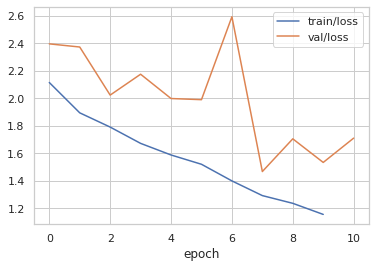

In [24]:
df[["train/loss", "val/loss"]].plot()
plt.show()

Test Log

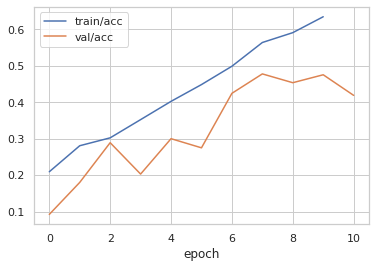

In [25]:
df[["train/acc", "val/acc"]].plot()
plt.show()

## [4] Test

### 4-1: Get prediction results for each sequences.

In [26]:
datamodule.setup("test")
dataloaders = datamodule.test_dataloader()
split = cfg.dataset.split.test


outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on {user}-{session}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.path.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"{user}-{session}"] = {
        "t_idx": plmodel.test_results.get("t"),
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

2022-06-28 16:58:47 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 16:58:49 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 16:58:50 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-06-28 16:58:50 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-06-28 16:58:50 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-06-28 16:58:50 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackKeypoint object at 0x7f35ca109f10>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackKeypoint object at 0x7f34403527c0>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackKeypoint object at 0x7f343e0ad790>}
2022-06-28 16:58:50 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2022-06-28 16:58:50 | INFO | __main__ | test on U0106-S0100
2022-06-28 16:58:52 | WARNING | openpack_torch.data.datasets | No p

### 4-2: Evaluate

In [27]:
# compute performance summary
df_summary = eval_operation_segmentation_wrapper(
    outputs, OPENPACK_OPERATIONS,
)

AssertionError: values in array are expected to be monotonically increasing, but the minium step is -3278000.

In [ ]:
df_summary[df_summary["key"]=="all"]

## [5] Submission

### 5-1: Get prediction for test data.

In [ ]:
datamodule.setup("submission")
dataloaders = datamodule.submission_dataloader()
split = cfg.dataset.split.submission

outputs = dict()
for i, dataloader in enumerate(dataloaders):
    user, session = split[i]
    logger.info(f"test on U{user:0=4}-S{session:0=4}")

    trainer.test(plmodel, dataloader)

    # save model outputs
    pred_dir = Path(
        cfg.volume.logdir.predict.format(user=user, session=session)
    )
    pred_dir.mkdir(parents=True, exist_ok=True)

    for key, arr in plmodel.test_results.items():
        path = Path(pred_dir, f"{key}.npy")
        np.save(path, arr)
        logger.info(f"save {key}[shape={arr.shape}] to {path}")

    outputs[f"U{user:0=4}-S{session:0=4}"] = {
        "y": plmodel.test_results.get("y"),
        "unixtime": plmodel.test_results.get("unixtime"),
    }

### 5-2: Make submission zip file

In [ ]:
output_dir = Path(".")

submission_dict = construct_submission_dict(
    outputs, OPENPACK_OPERATIONS)
make_submission_zipfile(submission_dict, output_dir)